# Multivariate analysis step guide

for this tutorial in classification we gonna use the titanic dataset:
https://www.kaggle.com/datasets/yasserh/titanic-dataset

In [57]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [37]:
base = pd.read_csv("data/Titanic-Dataset.csv")
base.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


# Initial approach
initially we are to use a few variables and them we gonna increase the used ones!

In [33]:
df = base.copy()
df.drop(['PassengerId', 'Ticket', 'Cabin','Name'],axis=1,inplace=True, errors='ignore')
df = pd.get_dummies(df,columns=['Pclass','Embarked','Sex'],drop_first=True)
df['Age'].fillna(df['Age'].mean().astype(int),inplace=True)
df['const'] = 1

In [34]:
Xtrain = df.drop('Survived',axis=1)
ytrain = df[['Survived']]
   
model = sm.Logit(ytrain, Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.440186
         Iterations 6


to we have a baseline accuracy for our model we choose the highest!

In [35]:
ytrain.value_counts(normalize=True).round(2)

Survived
0           0.62
1           0.38
dtype: float64

so our baseline is 0.62 of accuracy, as our dataset is not so much unbalanced in the target we can keep using accuracy as metric but if was too much important that we find the ones that are dead even if is a false alarm we would go for precision (from the people that is dead, how many are dead) we gonna export metric views in terms of sklearn report to understand our model performance and the statsmodels view to understand the feature usage

In [38]:
print("Training")
print(classification_report(ytrain,model.predict(Xtrain).round().astype(int)))
model.summary()

Training
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       549
           1       0.77      0.70      0.73       342

    accuracy                           0.80       891
   macro avg       0.80      0.79      0.79       891
weighted avg       0.80      0.80      0.80       891



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      881
Method:                           MLE   Df Model:                            9
Date:                Sat, 21 May 2022   Pseudo R-squ.:                  0.3390
Time:                        17:08:27   Log-Likelihood:                -392.21
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 4.550e-81
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.0389      0.008     -4.946      0.000      -0.054      -0.024
SibSp         -0.3219      0.109     -2.941      0.003      -0.536      -0.107
Parch         -0.0948      0.119     -0.797      0.426      -0.328       0.138
Fare           0.0023      0.002      0.927      0.354      -0.003       0.007
Pclass_2      -0.9222      0.298     -3.097      0.002      -1.506      -0.339
Pclass_3      -2.1507      0.298     -7.221      0.000      -2.734      -1.567
Embarked_Q    -0.0493      0.381     -0.129      0.897      -0.796       0.698
Embarked_S    -0.4503      0.239     -1.882      0.060      -0.919       0.019
Sex_male      -2.7162      0.201    -13.506      0.000      -3.110      -2.322
const          4.0957      0.475      8.625      0.000       3.165       5.026
==============================================================================
"""

so in a first view we can see that fare and parch are not useful but thats right? remember that the log reg uses a linear approach and this may not be true, and the same for embarked_Q, maybe there is any interaction with this embarked that could improve it?? or maybe the effect on Q is already into another feature? like age or fare and Q is really not important?

# Using decision tree for feature analysis

decision tree take some time to run due it goes for each possible threshold of your features and check the best one and do a split and after scan and do it again, why is this useful? because you can see the most important splits of your variables like decisions! you gonna understand it better, just watch

In [46]:
df = base.copy()
df.drop(['PassengerId', 'Ticket', 'Cabin','Name'],axis=1,inplace=True, errors='ignore')
df = pd.get_dummies(df,columns=['Pclass','Embarked','Sex'],drop_first=True)
df['Age'].fillna(df['Age'].mean().astype(int),inplace=True)

In [79]:
Xtrain = df.drop('Survived',axis=1)
ytrain = df[['Survived']]

model = DecisionTreeClassifier(max_depth=4, random_state=42, min_samples_leaf=20, min_samples_split=0.1)
model.fit(Xtrain, ytrain)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, min_samples_split=0.1,
                       random_state=42)

why i chooosed this parameters? because i want a redable tree and also avoid overfitting into a choice

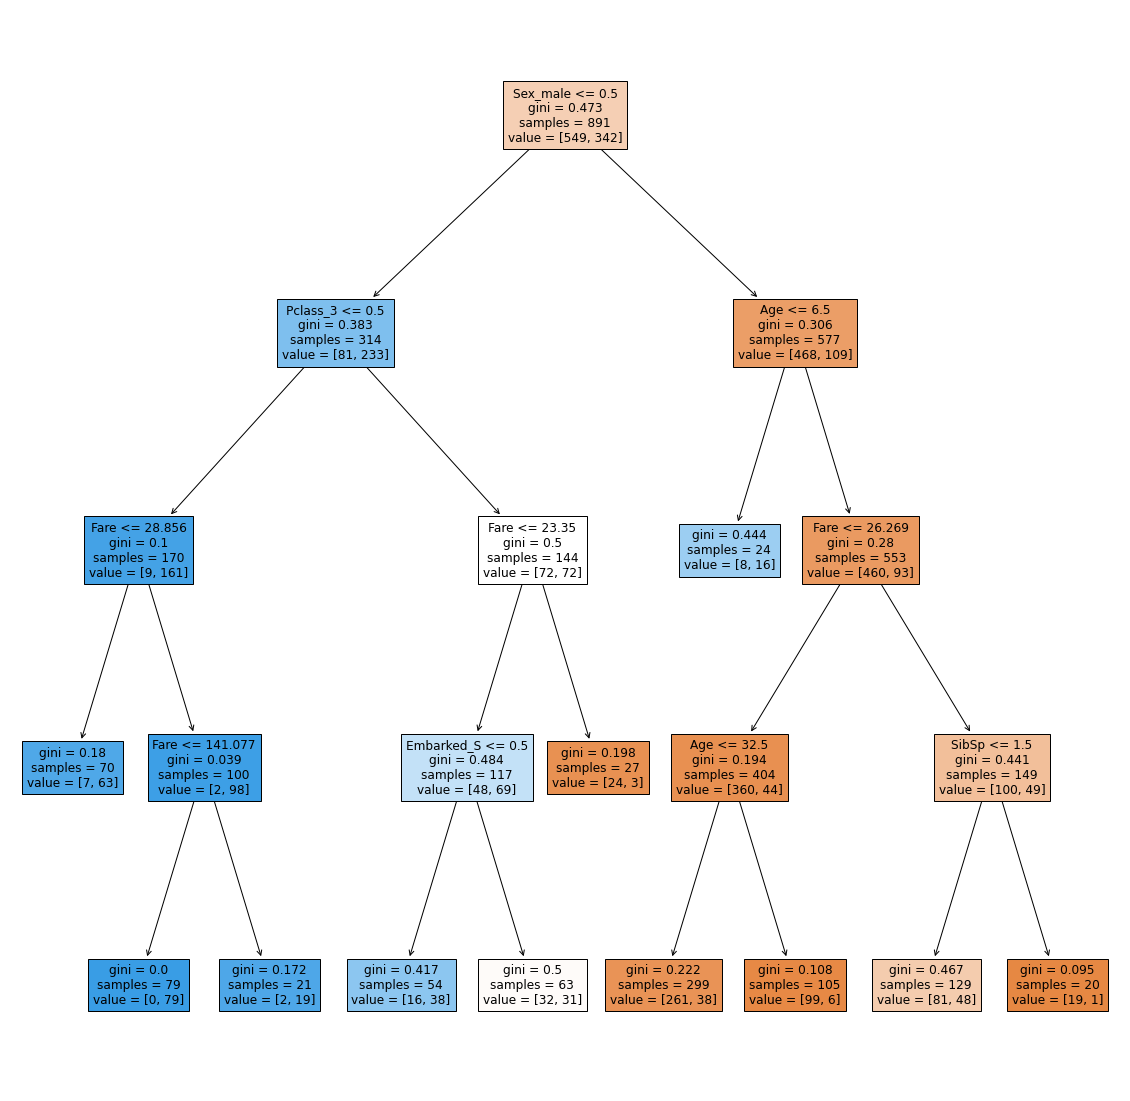

In [81]:
plt.figure(figsize=(20,20))
plot_tree(model, feature_names=Xtrain.columns, proportion=False, filled=True)
plt.show()

for this remember that gini impurity index is the probability of pick a two different elements, so it shows a score of diversity into a sample so less it is, less diverse is the sample!

- we can see that sex is the most important splitter (would be weird is someone just read this part but ok)
- that are interactions between fare and pclass that we didn't saw before
- interaction between fare and age
- interaction between sex, pclass and age
- we can see that fare between a range 
- and much more!

lets see the feature importance?

In [90]:
pd.Series(
    model.feature_importances_,
    model.feature_names_in_
).sort_values().to_frame("Importance")

,Importance
Parch,0.000000
Pclass_2,0.000000
Embarked_Q,0.000000
Embarked_S,0.013331
SibSp,0.018388
Age,0.062398
Fare,0.109582
Pclass_3,0.159492
Sex_male,0.636809


lets apply some feature enginnering!

In [95]:
df['male_pclass3'] = df['Sex_male'] * df['Pclass_3']
df['sex_age'] = df['Age'] * df['Sex_male']
df['Fare_above28'] = (df['Fare'] > 28.85).astype(int)
df['const'] = 1

In [96]:
df

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Embarked_Q,Embarked_S,Sex_male,male_pclass3,sex_age,Fare_above28,const
0,0,22.0,1,0,7.2500,0,1,0,1,1,1,22.0,0,1
1,1,38.0,1,0,71.2833,0,0,0,0,0,0,0.0,1,1
2,1,26.0,0,0,7.9250,0,1,0,1,0,0,0.0,0,1
3,1,35.0,1,0,53.1000,0,0,0,1,0,0,0.0,1,1
4,0,35.0,0,0,8.0500,0,1,0,1,1,1,35.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,1,0,0,1,1,0,27.0,0,1
887,1,19.0,0,0,30.0000,0,0,0,1,0,0,0.0,1,1
888,0,29.0,1,2,23.4500,0,1,0,1,0,0,0.0,0,1
889,1,26.0,0,0,30.0000,0,0,0,0,1,0,26.0,1,1


In [97]:
Xtrain = df.drop('Survived',axis=1)
ytrain = df[['Survived']]
   
model = sm.Logit(ytrain, Xtrain).fit()
print("Training")
print(classification_report(ytrain,model.predict(Xtrain).round().astype(int)))
model.summary()

Optimization terminated successfully.
         Current function value: 0.420984
         Iterations 7
Training
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       549
           1       0.82      0.67      0.74       342

    accuracy                           0.82       891
   macro avg       0.82      0.79      0.80       891
weighted avg       0.82      0.82      0.81       891



<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      878
Method:                           MLE   Df Model:                           12
Date:                Sat, 21 May 2022   Pseudo R-squ.:                  0.3678
Time:                        18:56:47   Log-Likelihood:                -375.10
converged:                       True   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 7.061e-86
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Age             -0.0258      0.014     -1.840      0.066      -0.053       0.002
SibSp           -0.3292      0.115     -2.860      0.004      -0.555      -0.104
Parch           -0.0901      0.130     -0.692      0.489      -0.345       0.165
Fare             0.0002      0.003      0.096      0.923      -0.005       0.005
Pclass_2        -1.2710      0.394     -3.226      0.001      -2.043      -0.499
Pclass_3        -3.7604      0.556     -6.767      0.000      -4.850      -2.671
Embarked_Q       0.0116      0.365      0.032      0.975      -0.704       0.727
Embarked_S      -0.5069      0.244     -2.077      0.038      -0.985      -0.028
Sex_male        -3.3131      0.681     -4.862      0.000      -4.649      -1.978
male_pclass3     2.1256      0.493      4.316      0.000       1.160       3.091
sex_age         -0.0283      0.017     -1.641      0.101      -0.062       0.006
Fare_above28     0.2863      0.337      0.849      0.396      -0.375       0.947
const            4.9921      0.710      7.027      0.000       3.600       6.385
================================================================================
"""

ok now we improve our accuracy and our pseudo R², we can see that age seems to have a negative effect, be male also, be 3 class too and all of this makes sense right? if you are in the 3 class probably there not much safety than the 1 class, also think about women and kids first, and also if your age is higher there is a higher change of you die but depends of course! for sure is not linear! but you can look for sweetviz report to see this better

but now is missing to we have a good confidence into our model we are training and testing in the same dataset this is a problem, how can we fix this?

also to improve our pseudo R² we can drop features that are not too many useful

what are the future steps to improve this analysis??